<a href="https://colab.research.google.com/github/janbogar/czechitas-transformers/blob/main/czechitas-BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers for text processing

Transformers are neural networks that changed how we model sequential data.

There are many kinds of data that are sequential in nature, for example time series, but e.g. a text is also just a sequence of words.

State of the art in these areas used to be recurrent neural networks. They work by sequentially taking as an input not just each item in the sequence, but also the output of the network on the previous item. This way, the output of the network can contain the memory of what happened previously.

The problem with recurrent neural networks was difficulty of training them in parallel. They also had trouble learning relationships between words that were far away from each other.

Transformers work quite differently. All of the sequence is shown to the network at once, and a special architecture called attention head (transformers usually have multiple) predict to which parts of sentence should the network pay attention when processing each word.

Famous language models based on transformers are e.g. BERT and GPT3, but there are many more variants, such as RoBERTa, ALBERT, sBERT or ELECTRA.

# Model
In this notebook we will use BERT model trained and published by researches at West Bohemia University. The model is called Czert and the authors experimented with it on many tasks:
 - Sequence Classification (**Sentiment Classification**, Multi-label Document Classification)
 - Sequence Pair Classification (Semantic Text Similarity)
 - Token Classification (Morphological Tagging, Named Entity Recognition,
Semantic Role Labeling)

The model:
https://huggingface.co/UWB-AIR/Czert-B-base-cased

The paper:
https://arxiv.org/pdf/2103.13031.pdf

# Sentiment analysis

In this notebook, we will use the model trained specifically for sentiment analysis. In the sentiment analysis task, the model attempts to classify short texts (often social media statuses or customer reviews) as either positive, negative or neutral.

The authors published two versions of the model, one trained on reviews from www.csfd.cz and the other trained on facebook posts. Both datasets are available on their website.

The authors claim, that this model had F1 score of 77% on CSFD data and 85% percent on FB data, which they claim are better than the state of the art before this model was published.
F1 score is hard to interpret without knowledge of precision and recall metrics, but for now, let's just say it corresponds somehow to the accuracy of the model.

If the model had 75% accuracy, it would still make an error in one quarter of cases. That means that there is still a huge potential for error.
This is something to keep in mind whenever you are deciding on a specific model: what is the minimal acceptable accuracy for my use-case?

In the following cells, we will download this model and attempt to use it.

## Install dependencies

In [ ]:
!pip install transformers
!pip install sentencepiece

**!! Restart runtime after installing !!**

Go to the top of the page, press 'Runtime" and select "Restart runtime".

## Download model
There are two variants of the model, we will download the one trained on FB data and unzip it.

In [59]:
#!wget https://air.kiv.zcu.cz/public/CZERT-B_csfd.zip
!wget https://air.kiv.zcu.cz/public/CZERT-B_fb.zip

--2022-12-05 12:11:00--  https://air.kiv.zcu.cz/public/CZERT-B_fb.zip
Resolving air.kiv.zcu.cz (air.kiv.zcu.cz)... 147.228.63.35
Connecting to air.kiv.zcu.cz (air.kiv.zcu.cz)|147.228.63.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 406510308 (388M) [application/zip]
Saving to: ‘CZERT-B_fb.zip.2’

CZERT-B_fb.zip.2    100%[===================>] 387.68M  7.30MB/s    in 59s     

2022-12-05 12:12:00 (6.56 MB/s) - ‘CZERT-B_fb.zip.2’ saved [406510308/406510308]



In [60]:
!unzip -o CZERT-B_fb.zip

Archive:  CZERT-B_fb.zip
  inflating: CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/config.json  
  inflating: CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/pytorch_model.bin  
  inflating: CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/special_tokens_map.json  
  inflating: CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/tokenizer_config.json  
  inflating: CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/vocab.txt  


# Load the model
This model is implemented as a HuggingFace transformer. 
This means they have a very convenient API and can be easily loaded and reused.
I highly recommend their course at:
https://huggingface.co/course/chapter1/1

In [61]:
from transformers import AutoTokenizer, BertForSequenceClassification
import tensorflow

#model_path="CZERT-B_csfd_BS-14_EC-12_LR-0-0000200_LEN-512_SCH-linear_wrp_CPU-False_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-12-06_10-30_07-494882_F1-0.8467/"
model_path="CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598"

model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

## What is a tokenizer

Neural networks accept as an input vectors or matrices of numbers, so we need to turn texts that we want to input into the model into vectors.

Tokenizer is a program that does that. It splits the data into tokens and then assigns each token a number.
There is no universally optimal way to tokenize text and many approaches can be used, depending on the specific use case.
Transformers usually use sub-word tokenization. Here is an example:


In [62]:
sentence = "Za hory, za doly, mé zlaté parohy"
sentence_tokens = ["[CLS]"] + tokenizer.tokenize(sentence) + ["[SEP]"]
sentence_encoding=tokenizer.encode(sentence)
print("tokens:" ," ".join([f"\'{i}\'" for i in sentence_tokens]))   
print("encoding: ",sentence_encoding)


tokens: '[CLS]' 'za' 'hory' ',' 'za' 'dol' '##y' ',' 'me' 'zlat' '##e' 'par' '##oh' '##y' '[SEP]'
encoding:  [2, 1967, 12378, 16, 1967, 10864, 1036, 16, 2913, 7218, 1011, 2667, 2596, 1036, 3]


The tokenizer split some words into multiple tokens and added special tokens and marks:
 - `[CLS]` token is always added at the start of the text. Transformer outputs one vector per each token, and the vector for `[CLS]` token is used for the classification of whole sentences.

- `[SEP]` token: transformers are also trained on tasks including relationship of multiple texts. In that case, texts are separated by this special token.

- `[PAD]` token was not used in this case, but if there is a need to make multiple sequences the same length, the unused space is filled with `[PAD]` tokens.

- `##oh` token: the word `parohy` was split into tokens `par`,`oh` and `y`. To signal to the model that the tokens `oh` and `y` were not at the start of the word, they are prepended with `##`.

After splitting the text and adding special tokens, every token is turned into a number, based on its position in the vocabulary- the document containing all tokens known to the model. If some token is not in the vocabulary, it is replaced with a special token `[UNK]`. The vocabulary file was downloaded together with the model, and in this case contains one word per line, so if we want to see how many words it contains, we just count the lines in it:


In [63]:
!wc -l CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/vocab.txt

30000 CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/vocab.txt


Here are the last 10 tokens in the vocabulary:

In [64]:
! tail -n 10 CZERT-B_fb_BS-32_EC-12_LR-0-0000020_LEN-64_SCH-linear_wrp_CPU-True_TRAIN-True_CUST_LAYER-False_BINARY-False_2020-11-30_13-00_40-335326_F1-0.7598/vocab.txt

záchranář
zahrála
repr
Britská
stěže
izp
řešíme
##váří
##natý
Jerem


# Using the model

Now that we know how to preprocess the input texts, let's try the model on some examples.

In [65]:
test_strings = ["Pivo je skvělý.","Pivo příšerně chutná, je nezdravé a je vstupnou bránou k alkoholizmu. Jednoduše fuj.","Dávam tomuhle pivu 50 procent."]

print("Raw sentences:\n",test_strings)
tokenized_inputs = tokenizer(test_strings, return_tensors="pt", padding=True)
print("\nInput of the model after tokenization:\n", tokenized_inputs)

outputs = model(**tokenized_inputs)
print("\nOutput of the model:\n", outputs)

Raw sentences:
 ['Pivo je skvělý.', 'Pivo příšerně chutná, je nezdravé a je vstupnou bránou k alkoholizmu. Jednoduše fuj.', 'Dávam tomuhle pivu 50 procent.']

Input of the model after tokenization:
 {'input_ids': tensor([[    2, 10671,  1955, 15584,  3312,    18,     3,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [    2, 10671, 10769,  9930,  2121, 24056,  1999,    16,  1955, 16840,
          2059,  1011,    69,  1955,  4073,  2104,  4181,  1929,    79, 27696,
          1021,  2028,    18,  4234,  2349, 11293,  1026,    18,     3],
        [    2, 10203,  2058,  2555,  3045,  8828,  1025,  3784,  2662,    18,
             3,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

As we can see, the output of the model contains a matrix of numbers called logits.
Logits are numbers between minus infinity and  plus infinity that represent probability. They can be turned into probability distribution (i.e. a set of numbers between 0 and 1 that together add up to 1) by softmax function.


In [66]:
from torch.nn.functional import softmax
softmax(outputs.logits)  #turn into probabilities (so they are between 0 and 1 and sum into 1)

<ipython-input-66-45e692d90b33>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax(outputs.logits)  #turn into probabilities (so they are between 0 and 1 and sum into 1)


tensor([[0.0030, 0.9801, 0.0168],
        [0.9805, 0.0089, 0.0106],
        [0.0860, 0.0561, 0.8579]], grad_fn=<SoftmaxBackward>)

Each row in this matrix is prediction for one input text. There are three numbers for each text:
 - probability of the text being negative
 - probability of the text being positive
 - probability of the text being neutral

You can check yourself that they add to 1.


In the next cells, we gather all of this code into one function, which will accept a list of texts and will make a prediction for each one.
I also wrote a function that will print the prediction nicely.

In [67]:
import numpy as np

id2label={0:"negative",1:"positive",2:"neutral"}
label2id={v:k for k,v in id2label.items()}

def get_predictions(texts):
  """Function that accepts a list of texts and outputs an iterator of dictionaries with predictions."""
  for text in texts:
    tokens=tokenizer(text, return_tensors="pt",truncation="only_first",max_length=512)
    model_output=model(**tokens)
    probabilities=softmax(model_output.logits[0],dim=0).detach().numpy()
    highest_probability=np.argmax(probabilities)
    yield {"text":text,                                                          # input text
           "probabilities":{k:probabilities[v] for k,v in label2id.items()},     # probabilities of each class (negative,positive and neutral)
           "prediction":id2label[highest_probability],                           # prediction: the label of the class with highest probability
           "prediction_confidence":probabilities[highest_probability]}           # prediction confidence: the probability of the class with the highest probability

def print_predictions(predictions):
  """Function that prettyprints predictions produced by get_prediction function."""
  for i in predictions:
    print(f"{i['prediction']} ({i['prediction_confidence']:.2f}): \"{i['text']}\"")

In [68]:
example_texts=["tohle je skvele, nejradeji bych to delal cely den","je to hrozna otrava, nejradeji bych to zakazal","davam 50 procent, neurazi"]

print_predictions(get_predictions(example_texts))

positive (0.93): "tohle je skvele, nejradeji bych to delal cely den"
negative (0.98): "je to hrozna otrava, nejradeji bych to zakazal"
neutral (0.70): "davam 50 procent, neurazi"


## Exercise 1

Use the code in the previous cell to find sentences that will fool the model in these ways:
 - the model will output negative if the sentence is positive
 - the model will output positive if the sentence is negative
 - the model will output neutral if the sentence is either positive or negative
 - the model will output positive or negative if the sentence is neutral

Which one is the hardest?

Which is harder, to fool the model if the text is long or if it is short?

In [14]:
#do the exercise!

# Watching politicians

Let's use this model for good: monitoring politicians.

We can try to classify their posts on social media as positive, negative and neutral. Maybe that can tell us us something about their authors.

# Where to get the data

Luckily, there is a webpage called Hlidac Statu, which collected a huge dataset of social media interactions of czech politicians (and many other useful datasets).

In the next few cells, we will write a function that will download this data.

However to access it, you will need to register on www.hlidacstatu.cz
To do so, follow these steps:
 - Go to https://www.hlidacstatu.cz/Identity/Account/Login?returnUrl=/
 - Login with your google account or register in other way
 - After logging in, click on your profile (top right corner)
 - In the menu on left, click the "API klic"
 - Copy the API key
 - Replace the string in the next code cell with your key

In [80]:
auth_key="<your API key>"

This code uses the requests library to access the web API of Hlidac Statu and downloads one page of posts of Petr Fiala he made on Facebook.
Pay attention to the params argument.

We print out the first 5 texts.

In [69]:
import requests as rq

In [70]:
response=rq.get("https://api.hlidacstatu.cz/Api/v2/datasety/vyjadreni-politiku/hledat",params={'dotaz':"server:Facebook AND osobaid:petr-fiala","strana":1},headers={"Authorization":auth_key})
results=response.json()["results"]
texts=[i["text"] for i in results]
texts[:5]

['',
 'Děkuji za jednomyslnou nominaci na předsedu ODS delegátům jihočeské ODS. Gratuluji Martinu Kubovi k jasnému obhájení pozice předsedy regionu. Jihočeská ODS získala v nedávných parlamentních volbách nadprůměrný výsledek. V Janu Zahradníkovi a nově i v Janu Bauerovi mají jihočeští voliči výborné zástupce v Poslanecké sněmovně, kteří dobře reprezentují naši politiku.',
 'Dnes se snaží Listopad 89 využít ve svůj prospěch různí populisté, extremisté, komunisté a dokonce bývalí agenti StB. Nedovolme jim to. \n\nPřipomínejme si, co se tehdy skutečně dělo, mluvme s lidmi, kteří si tu dobu pamatují, kteří se revoluce aktivně účastnili. Proto pořádáme sérii diskuzí na mnoha místech naší země. \n\nRád se s Vámi uvidím například 9. října v Praze. https://www.ods.cz/30-let-svobody/setkani',
 '"Letní interview" s moderátorkou Michaelou Šmídovou. Neobvyklé prostředí s krásným výhledem na Prahu, ale mluvili jsme hodně o Brně a o Moravě. :-) Kromě politiky jsme si povídali třeba o italské kuchyn

To simplify our workflow, we wrap this code up as a function in the next cell.
This function downloads 300 latest Facebook posts of a chosen politician that are in the database.
The name of the politician must be lowercased and the spaces in it exchanged for a `-` sign (due to the design of the database).

So "andrej-babis" instead of "Andrej Babis"

In [71]:
def get_page(name,page):
  response=rq.get("https://api.hlidacstatu.cz/Api/v2/datasety/vyjadreni-politiku/hledat",params={'dotaz':f"server:Facebook AND osobaid:{name}","strana":{page},"sort":"datum","desc":1},headers={"Authorization":auth_key})
  return response.json()

def get_texts(name,at_most=300):
  """
  Download 300 newest posts of a politician in the database. Selects only posts made to Facebook.
  """
  current_page=0
  texts=[]
  
  page=get_page(name,current_page)
  total_in_database=page["total"]
  print("total in database: ",total_in_database)

  texts+=[i['text'] for i in page["results"]]
  print(f"page: {current_page}, texts_so_far: {len(texts)}")
  
  while not (len(texts)>=at_most or len(texts)>=total_in_database):
    current_page+=1
    page=get_page(name,current_page)
    texts+=[i['text'] for i in page["results"]]
    print(f"page: {current_page}, texts_so_far: {len(texts)}")
  
  if len(texts)>at_most:
    texts=texts[:at_most]
  return texts

Let's download the posts of Andrej Babiš.

In [72]:
name="andrej-babis"
texts=get_texts(name)


total in database:  10308
page: 0, texts_so_far: 25
page: 1, texts_so_far: 50
page: 2, texts_so_far: 75
page: 3, texts_so_far: 100
page: 4, texts_so_far: 125
page: 5, texts_so_far: 150
page: 6, texts_so_far: 175
page: 7, texts_so_far: 200
page: 8, texts_so_far: 225
page: 9, texts_so_far: 250
page: 10, texts_so_far: 275
page: 11, texts_so_far: 300


Now let's use the model to process these posts. It can take up to a few minutes, depending on the length of the posts. We than print the first five predictions.

In [73]:
from tqdm import tqdm   # tqdm is a python package for nice progress bars

predictions=list(tqdm(get_predictions(texts),total=len(texts),desc="processing texts"))

processing texts: 100%|██████████| 300/300 [00:38<00:00,  7.75it/s]


In [74]:
print_predictions(predictions[:5])   # it seems the latest posts in the database are from the end of 2021

positive (0.53): "Je Nový rok. Velký svátek naší země a nás všech. A já mám něco na srdci ❤️"
neutral (0.98): "Ode mě pro Vás. Můj neuvěřitelný rok 2021 ve fotkách. Třeba se tam najdete ❤️"
neutral (0.97): "Kupuju obytňák!"
neutral (0.97): "Kupuju obytňák!"
neutral (0.79): "Je to tady. Kupuju obytňák!"


In the next cell, let's take a look at probability distribution of confidences of predicted labels.

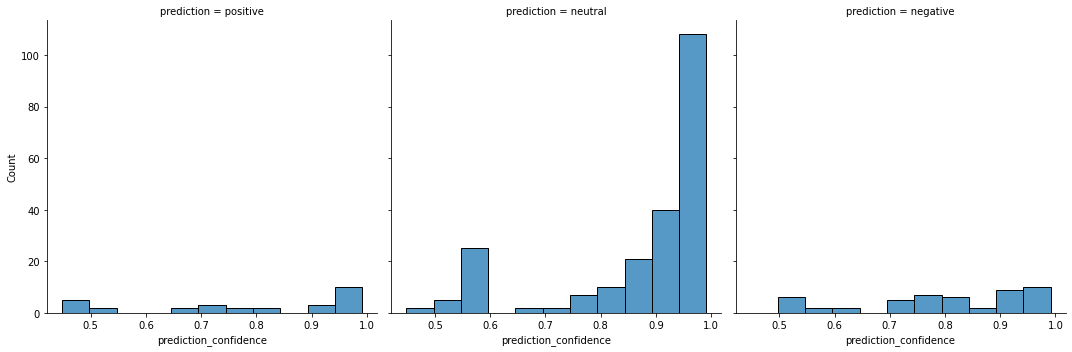

In [75]:
import seaborn as sb
import pandas as pd
sb.displot(pd.DataFrame(predictions),x="prediction_confidence",col="prediction")

Looks like the model is usually only confident about neutral predictions of Andrej Babis (most such predictions have high confidence) and much less confident about the positive and negative predictions.

------
## Question 1:

Is this because of the data (positive and negative statements are written in relatively neutral way, compared to the training data), or is it because of the model (model is somehow biased towards neutral sentences)?

How could we find out?

#### Author's opinion:

Without an experiment, this question cannot be answered - it is impossible to say whether something is an error of the model or a real feature of the data without a deeper look at both the model and the data.

The best way to do this is to prepare our own testing dataset.
What I would do:
 - Select 500 (or maybe even 1000) random statuses. They should be from different politicians and from different times (so we avoid them being all about the same topic that was important at the time of their writing)
 - Read each one and label it as either positive, negative or neutral. With 3s per post, it should take less than half an hour.
 - Use the model to make a prediction for each post.
 - Calculate the confusion matrix. Confusion matrix is a table with columns corresponding to predicted labels, and rows to the actual labels. Each cell then contains the number of datapoints with given actual label and given predicted label, relative to the total number of datapoints. Confusion matrix of the best possible model would have zeroes everywhere but on a diagonal. Values outside of the diagonal are probabilities of the model committing different types of errors (we already encountered different kinds of errors in the Exercise 1. Which cells in the confusion matrix corresponds to which kind of error?)). This alone should answer whether the model is biased towards classifying posts as neutral or not. Confusion matrix is one of the most valuable concepts for the model performance analysis.
 - Analyze some of the errors of the model. Print out 10 posts that were erroneously classified with the highest confidence (maybe do so for each error category, i.e. Neutral to Positive, Positive to negative, etc.) and read them. Is there some pattern? What kind of errors are these? This will help you understand what kind of errors is the model making and also set the threshold for confidence of the predictions (there are also more rigorous ways of doing this, but this is good for now).

-------

Let's say we would like to select the most extreme examples of politicians posts on the sentiment spectrum. In the next cell, we attempt to do this by selecting the positive/negative posts with the highest confidence.



In [76]:
print("highest positive confidence: ", max([i for i in predictions if i["prediction"]=="positive"],key=lambda x: x["prediction_confidence"]))
print("highest negative confidence: ", max([i for i in predictions if i["prediction"]=="negative"],key=lambda x: x["prediction_confidence"]))

highest positive confidence:  {'text': 'Je tady fajn 🚴\u200d♀️😂', 'probabilities': {'negative': 0.002989264, 'positive': 0.9914219, 'neutral': 0.0055887913}, 'prediction': 'positive', 'prediction_confidence': 0.9914219}
highest negative confidence:  {'text': 'Už to do zítra nevydržím, tady to máte.', 'probabilities': {'negative': 0.9691094, 'positive': 0.003227884, 'neutral': 0.02766266}, 'prediction': 'negative', 'prediction_confidence': 0.9691094}


## Question 2:

The previous cell contains the posts where the model was the most confident about them being either positive or negative. Is it the same thing as the posts actually being "the most positive / the most negative"?

What would we need to do to get these answers from the model?

#### Author's opinion
It's always necessary to keep in mind what the model output actually means.

There are two layers to this question. First, the obvious one:

Confidence is not intensity. The confidence measures how much the model is sure of its answer. As an example, imagine a post which is strongly negative, but which uses a complicated metaphor or sarcasm to express that. The model would likely have low confidence in its prediction, even though the intensity of the sentiment would be really strong.

We can only get the information about the intensity of the sentiment from our three classes: negative, neutral or positive. If we wanted a more detailed resolution, we could e.g. predict 5 classes: strongly negative, negative, neutral, positive and strongly positive. Or we could, instead of classification, train the model to do regression, i.e. predict for each post a single sentiment score, e.g. a real number from -1 to 1. In both of these cases, we would have to retrain the model, because it just wasn't trained to do any of this.

The second layer to this question is that the confidence itself means something else to us humans than it does to the model.
Confidence of the model is a measure of how far in the feature space is the specific post from the decision boundary.
For humans, confidence reflects how likely it is that unknown facts could change their conclusion. A post for which humans have high confidence can have low confidence for the model, and the other way round.

-----------

Let's look at the overall number of posts that are positive or negative.

We will select a threshold of 0.9 as a confidence threshold, above which we trust the model.
If the confidence is lower, we leave the post unclassified.

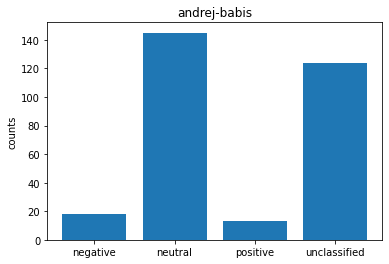

In [77]:
from matplotlib import pyplot as plt
threshold=0.9
only_confident=[i["prediction"] for i in predictions if i["prediction_confidence"]>threshold]
labels,counts=np.unique(only_confident,return_counts=True)
counts=list(counts)
labels=list(labels)
counts+=[len(predictions)-len(only_confident)]
labels+=["unclassified"]
plt.ylabel("counts")
plt.title(name)
plt.bar(labels,counts)
plt.show()

## Question 3
What does this plot say?
Does it match your expectations?
Is the model good enough for us to make conclusions about the author of these posts?

#### Author's opinion
The most of the posts were classified as neutral, and the second most likely outcome was unclassified due to low model confidence.

There are again two things to keep in mind here.
First, our confidence threshold was selected without any rigorous process. Maybe it was set too high, or too low. If we did perform an error analysis as suggested in the Author's Opinion on Question 2, we should be able to tell whether we could trust these results a little better.

However, without the error analysis, these results are untrustworthy.
What if all the unclassified results were instead positive? Or negative? Although this is unlikely, the overall picture would be very different.

Secondly, there is a problem of interpretation of the labels. What does "positive" even mean in this context? Is it hopeful and optimistic, or just "not vulgar and hateful"? This is not a property of the model, but of the dataset it was trained on.
We can get a feel for this interpretation by looking at the original dataset on which the model was trained. Some feeling for this can also be gained from the error analysis itself: if the model usually classifies weakly positive posts as neutral, maybe the annotators of the training data just had a higher threshold for considering something positive. This is something to always keep in mind when interpreting the model results - the meaning of the labels can be different than we expect.

From this and the previous questions, we see that even though our model was already trained, it is still useful to label a small test dataset ourselves, and perform a thorough model evaluation to ensure that our predictions are trustworthy and interpreted correctly.

## Excercise 2
In the next cell, see the results for another politician of your choice. Are they different?
Post your results (plots, not texts) into the gallery with the name of the politician.

In [ ]:
name="jozko-mrkvicka"
texts=get_texts(name)
predictions=list(tqdm(get_predictions(texts),total=len(texts),desc="processing texts"))

sb.displot(pd.DataFrame(predictions),x="prediction_confidence",col="prediction")
plt.show()

threshold=0.9
only_confident=[i["prediction"] for i in predictions if i["prediction_confidence"]>threshold]
labels,counts=np.unique(only_confident,return_counts=True)
counts=list(counts)
labels=list(labels)
counts+=[len(predictions)-len(only_confident)]
labels+=["unclassified"]
plt.ylabel("counts")
plt.title(name)
plt.bar(labels,counts)
plt.show()

print("highest positive confidence: ", max([i for i in predictions if i["prediction"]=="positive"],key=lambda x: x["prediction_confidence"]))
print("highest negative confidence: ", max([i for i in predictions if i["prediction"]=="negative"],key=lambda x: x["prediction_confidence"]))

# Appendix: Transfer learning
In the discussion of the previous questions, we encountered a few cases in which it would be nice to have a model that does something slightly different than the model we already have.

E.g. we might want to predict a positivity score with higher resolution than just negative, neutral and positive. Or, let's say we wouldn't want to classify the results as "negative", "neutral" and "positive", but as "polarizing", "neutral" and "reconciliatory". Another possibility is that we would find out in our model evaluation that the performance on our specific dataset is low, and we would like to improve it.

In all of these cases we could make use of the so-called transfer learning.

As is, the model obviously understands something about the czech language. It is assumed that in general, neural networks detect simple features in the first layers (in this case, the simplest being position and presence of words), and as we move into the deeper layers of the networks, the features are becoming more abstract and general (e.g. which word is the subject of the sentence). In the last layers of the model, these general features are combined to make a prediction on our specific task. If we wanted a new model for a similar task, we could leverage the general knowledge about the czech language that should be contained in the first layers of the model.

We have two options how to do that:

## Finetuning
We cut off the last few layers of the model and replace them with the layers that better suit our new needs (e.g. we could change how many output classes is recognized by the output layer). If the task doesn't require different architecture, we can skip this step and just keep the network as is.

Then we train the whole model again on a task specific dataset. This new dataset doesn't have to be as large as the original training dataset, because the model doesn't need to learn the rules of the czech language from it (the model already knows them), it only needs to learn how to perform the new specific task. It is likely that if we would do this, the layers that would change the most would be the last layers of the network. It is important to note that this approach doesn't rely on the model having general knowledge somewhere in its inner layers, it's just an advantage. If it is necessary for the training, weights in all of the layers can change. Because of this, this approach guarantees good performance. However, the disadvantage is we need to train all the parameters, which takes time.

Positives:
 - best performance
Negatives:
 - the model takes long to train

## Embeddings
We cut off the last few layers of the model, so that one of the hidden layers of the model is now an output layer. We feed or data into it and save the outputs. We then use these outputs as training data to train a smaller model to perform our task.

The output of some internal hidden layer of the network we just mentioned is usually called an "embedding". Since internal layers are usually large, it often has many dimensions (e.g. for transformers it could be 256 or 512). The hope is that this embedding reflects all the relevant features of the data, but is not yet specific to our task.

In theory, this is equivalent to finetuning the model, but forbidding the training of the first few layers. However, doing it this way is more practical and faster: the embeddings can be calculated for multiple datapoints in parallel, we don't have to recalculate them multiple times, and we can also use them for other tasks, unrelated to the training.

Negatives:
 - likely not as good as retraining the whole model

Positives:
 - faster training
 - other good uses of embeddings (e.g. you can search for similar records in the dataset by comparing their embeddings) 

This article contains a good discussion on this topic in the context of transformers: https://towardsdatascience.com/what-exactly-happens-when-we-fine-tune-bert-f5dc32885d76.
